In [33]:
# Modules classiques
import numpy as np
import pandas as pd

# Modules pour data-viz
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.io as pio
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.figure_factory as ff

# Options
pd.set_option("display.min_rows", 10)
pd.set_option("display.max_columns", 30)
pd.set_option("max_colwidth", 1000)

sns.set_style('darkgrid')
plt.rc('figure',figsize=(17,13))

# EDA
from wordcloud import *

# Preprocessing 
import re, string
from emoji import demojize

# Modélisation
from sklearn.feature_extraction.text import CountVectorizer

# Autres
from IPython.display import display
from PIL import Image

# Serialization
import pickle

# Distance text
from Levenshtein import distance

# Wordcloud
from nltk.corpus import stopwords
from wordcloud import WordCloud, ImageColorGenerator, get_single_color_func
import cv2
from nltk.stem import WordNetLemmatizer

# Lemmatizer
import spacy
from spacy_lefff import LefffLemmatizer, POSTagger
from spacy.language import Language


from IPython.display import display
import random
import dataframe_image as dfi 

# Fonctions utiles

In [2]:
useful_col = ['id', 'date', 'content', 'user',
              'replyCount', 'retweetCount', 'likeCount', 'quoteCount',
              'lang', 'sourceLabel', # lang pour filtrer ; sourceLabel pour stats
              'media', # Pour récupérer les photos
               # 'retweetedTweet', 
              'quotedTweet', 'inReplyToTweetId', # Savoir si c'est un retweet, une réponse, une quote...
              'mentionedUsers', # Pour repérer les comptes mentionnés le +
              'hashtags' # Pour voir la répartition 
              ]



def clean_dataset(df: pd.DataFrame, col_to_keep : list, since=None, until=None, debug=True):
    '''
    Cette fonction
    1. Conserve uniquement les colonnes utiles
    2. Restreint les tweets à un intervalle défini par [@since, @until]
    3. Supprime les tweets doublons, non français ou encore qui n'ont pas Kohlanta (sous forme de hashtag ou non) dans le contenu de leur tweet
    4. Extrait des informations essentielles 
    '''   
    
    if debug: 
        print('---------- Infos sur le dataset -----------')
        print(f'Taille initiale: {df.shape}')
    
    
    # 1. Conserve uniquement les colonnes utiles
    to_return = df[col_to_keep]
    
    # 2. Restreint les tweets à un intervalle défini par [@since, @until]
    to_return.date = to_return.date.apply(lambda x: x.astimezone('Europe/Paris'))
    tmp_shape = to_return.shape
    
    if since is not None:
        to_return = to_return[to_return.date >= since]
    if until is not None:
        to_return = to_return[to_return.date <= until]
        
    if debug: print(f'{tmp_shape[0] - to_return.shape[0]} tweets ne faisant pas partie de l\'intervalle de temps étudié supprimés.')
        
    # 3. Supprime les tweets doublons
    tmp_shape = to_return.shape
    to_return.drop(index=to_return[to_return.content.duplicated()].index, inplace=True)
    if debug: print(f'{tmp_shape[0] - to_return.shape[0]} duplicats supprimés.')
    
    # 3. Supprime les tweets non français
    tmp_shape = to_return.shape
    to_return.drop(index=to_return[to_return.lang != 'fr'].index, inplace = True)
    to_return.drop(labels='lang', axis='columns', inplace=True)
    
    if debug: print(f'{tmp_shape[0] - to_return.shape[0]} tweets non français supprimés.')
    
    # 3. Certains tweets ne parlent pas de Koh-Lanta mais mentionne quelqu'un qui possède cela dans son username
    tmp_shape = to_return.shape
    tweets_without_kohlanta_content = to_return[~(to_return.content.str.contains('Koh Lanta', case=False) | \
                                    to_return.content.str.contains('KohLanta', case=False) | \
                                    to_return.content.str.contains('Koh-Lanta', case=False) | \
                                    to_return.content.str.contains('Koh- Lanta', case=False) | \
                                    to_return.content.str.contains('Koh -Lanta', case=False))]

    to_return.drop(index=tweets_without_kohlanta_content.index, inplace=True)
    if debug: print(f'{tmp_shape[0] - to_return.shape[0]} tweets avec des usernames incorrects supprimés')
    
    # 4. Extrait des infos essentielles
    # Récupération de l'username
    user_name = to_return.user.apply(func = lambda x: x['username'])
    
    to_return.drop('user', axis='columns', inplace=True)
    to_return['user_name'] = user_name
    
    # Récupération des comptes mentionnés
    def users_mentioned(list_users):
        usernames = []
        for ind_user in range(0, len(list_users)):
            usernames.append(list_users[ind_user]['username'])
        return usernames
        
    tmp = to_return.mentionedUsers.fillna(value=np.nan)
    list_mentioned_users = tmp.apply(lambda x: users_mentioned(x) if type(x) == list else np.nan)
    
    to_return.drop('mentionedUsers', axis='columns', inplace=True)
    to_return['mentioned_users'] = list_mentioned_users
    
    # Le tweet est-il une réponse ?
    isReply = to_return.inReplyToTweetId.apply(lambda x: False if np.isnan(x) else True)
    
    to_return.drop('inReplyToTweetId', axis='columns', inplace=True)
    to_return['isReply'] = isReply
    
    # Le tweet est-il une quote ?
    isQuote = to_return.quotedTweet.apply(lambda x: False if x is None else True)
    
    to_return.drop('quotedTweet', axis='columns', inplace=True)
    to_return['isQuote'] = isQuote
    
    # Extraction de l'URL de la photo s'il en contient une
    def get_img_media_tweets(content):
        if not (content is None): # On vérifie que l'objet n'est pas nul avant d'accéder à son contenu
            if content[0]['_type'] == 'snscrape.modules.twitter.Photo':
                return content[0]['fullUrl']

        return np.nan # Si objet nul ou pas une photo
    
    urlImg = to_return.media.apply(get_img_media_tweets)
    
    to_return.drop('media', axis='columns', inplace=True)
    to_return['urlImg'] = urlImg 
    
    
    if debug:
        print('')
        print(f'Premier tweet: {to_return.date.min()}')
        print(f'Dernier tweet: {to_return.date.max()}')
        print(f'{isReply.sum()} tweets sont des réponses')
        print(f'{isQuote.sum()} tweets sont des quotes')
        print(f'{urlImg.notna().sum()} tweets contiennent des images')
        print('')
        print(f'{df.shape[0]-to_return.shape[0]} lignes supprimées au total')
        print(f'{df.shape[1]-to_return.shape[1]} colonnes supprimées au total')
        print(f'Nouvelle taille: {to_return.shape}')
        print('\n')
    
    return to_return.reset_index(drop=True)

In [3]:
compte_candidats = {
  '@TeheiuraTEAHUI':'teheuira',
  '@Laurentmaistret':'laurent',
  '@NamadiaKohlanta':'namadia',
  '@Blz_Freddy':'freddy',
  '@candicekohlanta':'candice',
  '@alixkohlanta':'alix',
  '@AlexandraKoh':'alexandra',
  '@loickohlanta':'loic',
  '@claude_KohLanta':'claude',
  '@karimakohlanta':'karima',
  '@Coumba_kohLanta':'coumba',
  '@MaximeKohLanta':'maxime',
  '@clemencecastel1':'clemence',
  '@jadekl7':'jade',
  '@DenisBrogniart':'denis',
}

def nlp_pipeline(text):
    '''
    Cette pipeline nettoie nos tweets, on part du moins restrictif (suppression de combinaison particulière) au plus restrictif 
    La pipeline suivie est la suivante:
    0. Remplace les noms des comptes candidats par leur prénom
    1. Passe l'ensemble du texte en minuscule
    2. Remplace les line feed et carriage return par des espaces
    3. Supprime les URLs
    4. Supprime les mentions
    5. Supprime tous les hashtags comment par #koh (insensible à la casse)
    6. Remplace les émoticons par leurs émotions correspondantes
    7. Supprime la ponctuation et les nombres
    
    '''

    for compte, nom in compte_candidats.items():
        text = text.replace(compte, nom)

    text = text.lower() # Passe l'ensemble du texte en minuscule
    text = text.replace('\n', ' ').replace('\r', '') # Remplace les line feed et carriage return par des espaces 
    text = re.sub(r'www\.\S+|https?\S+', '', text) # Supprime les URLs http ou https ou juste www.
    text = re.sub(r'@\S+', '', text) # Supprime les mentions ( Elles peuvent contenir le nom d'un twittos qui est le même que celui d'un candidat !)

    # text = re.sub(r'@\S+', '', text) # Supprime les mentions
    
    text = re.sub(r'#koh\S+', 'koh lanta', text, flags=re.IGNORECASE) # Supprime tous les hashtags commençant par #koh (insensible à la casse)
    text = text.replace('#', '') # Supprime les #
     
    text = demojize(text, language='fr') # Traite les emojis
#     text = text.replace('_', ' ')

    text = text.replace('é','e').replace('è', 'e').replace('ê', 'e').replace('ï','i') # Supprime les accents
    
#     for p in string.punctuation: # Supprime la ponctuation // text = re.sub(r'[!"#\$%&\'\(\)\*\+,-\.\/:;<=>\?@\[\\\]\^_`{\|}~]', '', text)
#         text = text.replace(p, '')
#     text = re.sub(r'[0-9]', '', text) # Supprime les nombres  

    return text

# Récupération et traitement des données brutes

In [4]:
em0 = pd.read_json('./data/emission_0.json', lines=True)
em1 = pd.read_json('./data/emission_1.json', lines=True)
em2 = pd.read_json('./data/emission_2.json', lines=True)
em3 = pd.read_json('./data/emission_3.json', lines=True)
em4 = pd.read_json('./data/emission_4.json', lines=True)
em5 = pd.read_json('./data/emission_5.json', lines=True)
em6 = pd.read_json('./data/emission_6.json', lines=True)
em7 = pd.read_json('./data/emission_7.json', lines=True)
em8 = pd.read_json('./data/emission_8.json', lines=True)
em9 = pd.read_json('./data/emission_9.json', lines=True)
em10 = pd.read_json('./data/emission_10.json', lines=True)
em11 = pd.read_json('./data/emission_11.json', lines=True)
em12 = pd.read_json('./data/emission_12.json', lines=True)
em13 = pd.read_json('./data/emission_13.json', lines=True)
em14 = pd.read_json('./data/emission_14.json', lines=True)

In [5]:
DEBUG = False

# Avant la première émission
until = pd.Timestamp('2021-08-24 21:05:00', tz='Europe/Paris')
tmp = pd.concat([em0, em1], ignore_index=True)

df_em0 = clean_dataset(df=tmp, col_to_keep=useful_col, until=until, debug=DEBUG)

# Emission 1
since = pd.Timestamp('2021-08-24 21:05:00', tz='Europe/Paris')
until = pd.Timestamp('2021-08-31 21:05:00', tz='Europe/Paris')
tmp = pd.concat([em1, em2], ignore_index=True)

df_em1 = clean_dataset(df=tmp, col_to_keep=useful_col, since=since, until=until, debug=DEBUG)

# Emission 2
since = pd.Timestamp('2021-08-31 21:05:00', tz='Europe/Paris')
until = pd.Timestamp('2021-09-14 21:05:00', tz='Europe/Paris')
tmp = pd.concat([em2, em3], ignore_index=True)

df_em2 = clean_dataset(df=tmp, col_to_keep=useful_col, since=since, until=until, debug=DEBUG)


# Emission 3
since = pd.Timestamp('2021-09-14 21:05:00', tz='Europe/Paris')
until = pd.Timestamp('2021-09-21 21:05:00', tz='Europe/Paris')
tmp = pd.concat([em3, em4], ignore_index=True)

df_em3 = clean_dataset(df=tmp, col_to_keep=useful_col, since=since,until=until, debug=DEBUG)

# Emission 4
since = pd.Timestamp('2021-09-21 21:05:00', tz='Europe/Paris')
until = pd.Timestamp('2021-09-28 21:05:00', tz='Europe/Paris')
tmp = pd.concat([em4, em5], ignore_index=True)

df_em4 = clean_dataset(df=tmp, col_to_keep=useful_col, since=since, until=until, debug=DEBUG)

# Emission 5
since = pd.Timestamp('2021-09-28 21:05:00', tz='Europe/Paris')
until = pd.Timestamp('2021-10-05 21:05:00', tz='Europe/Paris')
tmp = pd.concat([em5, em6], ignore_index=True)

df_em5 = clean_dataset(df=tmp, col_to_keep=useful_col, since=since, until=until, debug=DEBUG)

# Emission 6
since = pd.Timestamp('2021-10-05 21:05:00', tz='Europe/Paris')
until = pd.Timestamp('2021-10-12 21:05:00', tz='Europe/Paris')
tmp = pd.concat([em6, em7], ignore_index=True)

df_em6 = clean_dataset(df=tmp, col_to_keep=useful_col, since=since, until=until, debug=DEBUG)

# Emission 6
since = pd.Timestamp('2021-10-12 21:05:00', tz='Europe/Paris')
until = pd.Timestamp('2021-10-19 21:05:00', tz='Europe/Paris')
tmp = pd.concat([em7, em8], ignore_index=True)

df_em7 = clean_dataset(df=tmp, col_to_keep=useful_col, since=since, until=until, debug=DEBUG)

# Emission 8
since = pd.Timestamp('2021-10-19 21:05:00', tz='Europe/Paris')
until = pd.Timestamp('2021-10-26 21:05:00', tz='Europe/Paris')
tmp = pd.concat([em8, em9], ignore_index=True)

df_em8 = clean_dataset(df=tmp, col_to_keep=useful_col, since=since, until=until, debug=DEBUG)

# Emission 9
since = pd.Timestamp('2021-10-26 21:05:00', tz='Europe/Paris')
until = pd.Timestamp('2021-11-02 21:05:00', tz='Europe/Paris')
tmp = pd.concat([em9, em10], ignore_index=True)

df_em9 = clean_dataset(df=tmp, col_to_keep=useful_col, since=since, until=until, debug=DEBUG)

# Emission 10
since = pd.Timestamp('2021-11-02 21:05:00', tz='Europe/Paris')
until = pd.Timestamp('2021-11-09 21:05:00', tz='Europe/Paris')
tmp = pd.concat([em10, em11], ignore_index=True)

df_em10 = clean_dataset(df=tmp, col_to_keep=useful_col, since=since, until=until, debug=DEBUG)

# Emission 11
since = pd.Timestamp('2021-11-09 21:05:00', tz='Europe/Paris')
until = pd.Timestamp('2021-11-23 21:05:00', tz='Europe/Paris')
tmp = pd.concat([em11, em12], ignore_index=True)

df_em11 = clean_dataset(df=tmp, col_to_keep=useful_col, since=since, until=until, debug=DEBUG)

# Emission 12
since = pd.Timestamp('2021-11-23 21:05:00', tz='Europe/Paris')
until = pd.Timestamp('2021-11-30 21:05:00', tz='Europe/Paris')
tmp = pd.concat([em12, em13], ignore_index=True)

df_em12 = clean_dataset(df=tmp, col_to_keep=useful_col, until=until, debug=DEBUG)

# Emission 13
since = pd.Timestamp('2021-11-30 21:05:00', tz='Europe/Paris')
until = pd.Timestamp('2021-12-07 21:05:00', tz='Europe/Paris')
tmp = pd.concat([em13, em14], ignore_index=True)

df_em13 = clean_dataset(df=tmp, col_to_keep=useful_col, until=until, debug=DEBUG)

# Emission 14
since = pd.Timestamp('2021-12-07 21:05:00', tz='Europe/Paris')
until = pd.Timestamp('2021-12-14 21:05:00', tz='Europe/Paris')
# tmp = pd.concat([em13, em14], ignore_index=True)

df_em14 = clean_dataset(df=em14, col_to_keep=useful_col, until=until, debug=DEBUG)


In [132]:
df_em0.head(1)

,id,date,content,replyCount,retweetCount,likeCount,quoteCount,sourceLabel,hashtags,user_name,mentioned_users,isReply,isQuote,urlImg
0,1429956386822176768,2021-08-24 01:59:04+02:00,"Koh Lanta pardon, saison historique Jsuis excitée comme une ouf j’ai envie de manger des fajitas et boire du rhum",0,0,0,0,Twitter for iPhone,None,Namizo_ys,NaN,False,False,NaN


In [6]:
nom_candidats = ['Freddy', 'Teheuira', 'Patrick', 'Alexandra', 'Cindy', 'Claude', 'Karima', 'Jade', 'Maxime', 
                  'Laurent', 'Candice', 'Sam', 'Clementine', 'Ugo', 'Namadia', 'Christelle', 'Coumba', 'Loic', 
                  'Clemence', 'Phil', 'Alix', 'Denis']

In [7]:
dfs = [df_em0, df_em1, df_em2, df_em3, df_em4, df_em5, df_em6, df_em7, df_em8, df_em9, df_em10, df_em11, df_em12, df_em13, df_em14]

# Création des datasets

## NER (Détection des noms des candidats)

Ici, je repère l'ensemble des entités de personnes dans les tweets pour pouvoir déduire les appelations données à l'ensemble des candidats. <br>
Ensuite j'effectue une distance de similarité entre ces "appelations" et les noms réels des candidats. <br>
Cela me permet d'assigner l'ensemble des appelations à un candidat donné. <br>

Voir: https://www.baeldung.com/cs/string-similarity-edit-distance

In [17]:
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("Jean-Baptiste/camembert-ner")
model = AutoModelForTokenClassification.from_pretrained("Jean-Baptiste/camembert-ner")

nlp = pipeline('ner', model=model, tokenizer=tokenizer, aggregation_strategy="simple")

In [18]:
def trouve_surnoms(df:pd.DataFrame, nom_candidats: list):
       
    # Par batch de 512, récupère l'ensemble des entités "Personnes" trouvées dans le contenu des tweets
    persons = []
    start = 0
    for stop in range(0, df.shape[0], 512):
        output = nlp(' '.join(df.iloc[start:stop].content.values)) # Concatène 512 tweets en un seul string
        start = stop
        for entity in output:
            if entity['entity_group'] == 'PER':
                persons.append(entity['word']) # Ajoute l'entité reconnue à notre liste
      
    # On nettoie ici les noms/surnoms obtenus
    persons = list(map(lambda x: x.split(), persons)) # On éclate en un unique mots les entités contenant plusieurs mots (Ex: 'Claude le meilleur')
    clean = [] # clean est notre liste avec tous les surnoms trouvés écrits 'proprement'
    for nom in persons: # On passe notre liste en 1D
        if type(nom)==list:
            clean += nom
        else:
            clean.append(nom)
            
    clean = [nom for nom in clean if (len(nom) >= 3 and len(nom) < 13)] # On supprime les noms trop courts ou trop longs
    clean = np.unique(clean)
    
    # On calcule la distance de levenshtein entre les surnoms trouvés et les noms réels des candidats.
    # Pour ensuite classer dans un dict les trouvailles
    surnoms_trouves = {}
    for nom in nom_candidats:
        res = [] # res contient l'ensemble des distances noms - surnoms
        distance_max = round(len(nom)*0.33 - 1) # La distance de levenshtein maximum acceptée pour considérer cela comme une faute de frappe/Une autre appellation du candidat
        
        for entity in clean: # Calcul de la distance pour chaque entité trouvée
            res.append(distance(entity, nom.lower()))
        res = pd.Series(res)
        
        surnoms_trouves[nom] = clean[res[res <= distance_max].index] # Assigne les surnoms < à une certaine distance définie aux noms des candidats
        surnoms_trouves[nom] = np.append(surnoms_trouves[nom], nom.lower()) # Ajoute le nom du candidat à cette liste
        
        if nom == 'Teheuira':
            surnoms_trouves[nom] = np.append(surnoms_trouves[nom], 'tehe') # Exception pour teheuira où l'on connait un de ces surnoms populaire
        
        surnoms_trouves[nom] = np.unique(surnoms_trouves[nom]) # On supprime les doublons
                
    return surnoms_trouves

In [19]:
trouve_surnoms(df=df_em12, nom_candidats=nom_candidats)

{'Freddy': array(['freddy'], dtype='<U12'),
 'Teheuira': array(['Teheuira', 'Teheura', 'tehe', 'teheiura', 'teheuira'],
       dtype='<U12'),
 'Patrick': array(['patrick'], dtype='<U12'),
 'Alexandra': array(['Alexandra', 'alexandra'], dtype='<U12'),
 'Cindy': array(['cindy'], dtype='<U12'),
 'Claude': array(['Claude', 'claude'], dtype='<U12'),
 'Karima': array(['karima'], dtype='<U12'),
 'Jade': array(['jade'], dtype='<U12'),
 'Maxime': array(['maxime'], dtype='<U12'),
 'Laurent': array(['Laurent', 'laurent'], dtype='<U12'),
 'Candice': array(['candice'], dtype='<U12'),
 'Sam': array(['sam'], dtype='<U12'),
 'Clementine': array(['clementine'], dtype='<U12'),
 'Ugo': array(['ugo'], dtype='<U12'),
 'Namadia': array(['namadia'], dtype='<U12'),
 'Christelle': array(['Christelle', 'christelle'], dtype='<U12'),
 'Coumba': array(['Coumba', 'coumba'], dtype='<U12'),
 'Loic': array(['loic'], dtype='<U12'),
 'Clemence': array(['Clémence', 'clemence'], dtype='<U12'),
 'Phil': array(['phil'], dty

In [16]:
def save_all_surnames(until_em=14, dfs=dfs, nom_candidats=nom_candidats):
    for num in range(0, until_em+1):
        path_dict = f'./data_jugement/surnoms/surnoms_em{num}.pickle'
        df = dfs[num] # Récupère le dataset de l'émission
        df.content = df.content.apply(nlp_pipeline)
        
        d = trouve_surnoms(df=df, nom_candidats=nom_candidats)
        with open(path_dict, 'wb') as f:
            pickle.dump(d, f) # Sauvegarde l'ensemble des surnoms trouvés pour l'émission @num

In [ ]:
save_all_surnames(until_em=14, dfs=dfs, nom_candidats=nom_candidats)

In [15]:
def surnoms_trouves(nom, until_em = 14):
    '''
    Fonction permettant de trouver tous les surnoms trouvés pour un candidat
    '''
    result = []
    for ind in range(0,until_em+1):
        path = f'./data_jugement/surnoms/surnoms_em{ind}.pickle'
        d=pickle.load(open(path,'rb'))
        result.append(d[nom].tolist())
    return list(set(sum(result, []))), result

In [9]:
for nom in nom_candidats:
    all_results, result = surnoms_trouves(nom, 14)
    print(all_results)

['freddy']
['theura', 'tehueira', 'tehura', 'tehehura', 'teheuira', 'tehuira', 'heuira', 'teheura', 'teheiru', 'teiheura', 'tehe', 'teheiuira', 'tehoura', 'theheuira', 'tehiura', 'teheiura', 'theuira', 'teheirua']
['patrick', 'patrik']
['alexandra', 'lexandra']
['cindy']
['claud', 'claude']
['karima', 'karim']
['jade']
['maxim', 'maxime']
['laurant', 'laurent']
['candice']
['sam']
['clementine']
['ugo']
['amadia', 'namadia', 'namandia']
['christel', 'cristelle', 'christelle']
['cumba', 'comba', 'couba', 'coumva', 'coumba', 'koumba']
['loic']
['clemence', 'clement']
['phil']
['alix']
['dennis', 'donis', 'denis']


## Création de datasets par candidats

La cellule ci-dessous nous créé l'ensemble des datasets pour chaque candidats et pour chaque émission. <br>
Etapes: 
1. Nettoyage des tweets
2. Recherche des surnoms pour chaque candidat (Sauvegarde des surnoms trouvés dans un pickle dict)
3. Création du dataset du candidat en fonction des surnoms trouvés
4. Sauvegarde des datasets localement pour une réutilisation ultérieure !

In [20]:
#TODO: Sauver sous un autre format que .csv (trop lent)
# Pickle --> best (+ rapide ecriture / )
# (voir https://towardsdatascience.com/stop-using-csvs-for-storage-here-are-the-top-5-alternatives-e3a7c9018de0)

def save_datasets_candidates(from_em=0, until_em=14, nom_candidats=nom_candidats):
    for num in range(from_em, until_em+1): # On parcourt les datasets
        for nom in nom_candidats: # On parcourt les candidats
            path_to_save = f'./data_jugement/em{num}/'
            path_dict = f'./data_jugement/surnoms/surnoms_em{num}.pickle'
            end_file = f'{nom.lower()}.csv'
            
            df = dfs[num] # Récupère le dataset de l'émission
            df.content = df.content.apply(nlp_pipeline)
            
            all_results, result = surnoms_trouves(nom, until_em) # Récupère tous les surnoms trouvés pour un candidat
            pattern = '|'.join(list(map(lambda x: '\\b'+x+'\\b', all_results))) # Pattern à respecter
            reg_pattern = re.compile(pattern)
            
            to_save = df[df.content.str.contains(reg_pattern, regex=True)] # Récupère tous les tweets mentionnant @nom
            to_save.to_csv(path_to_save + end_file) # Sauvegarde le nouveau dataset


In [135]:
%%time
save_datasets_candidates(14,14)

Wall time: 4min 19s


## Tous les tweets faits sur un candidat

In [21]:
def all_infos(nom, until_em=14):
    '''
    Récupère toutes les données pour un candidat précis
    '''
    results= pd.DataFrame()
    for num in range(0,until_em+1):
        path = f'./data_jugement/em{num}/'
        df = pd.read_csv(path + nom.lower() + '.csv')
        results = pd.concat([results, df])
    return results.drop_duplicates(subset='content', )

# Calcul du score de popularité en fonction des mentions et des réactions

In [30]:
def gen_simple_fame_by_ep(nom, num_ep):
    path_to_load = f'./data_jugement/em{num_ep}/'
    
    def simple_fame(df, nom_candidats):    
        data = {
            'nb_tweets':df.shape[0],
            'nb_likes':df.likeCount.sum(),
            'nb_retweets':df.retweetCount.sum(),
    #         'nb_not_reply':df.isReply.sum(),
    #         'nb_image':df.urlImg.count()
        }

        return pd.DataFrame(data, index=nom_candidats)

    df = pd.read_csv(path_to_load + nom.lower() + '.csv')
        
    return simple_fame(df, [nom])

In [69]:
dfi.export(gen_simple_fame_by_ep('Teheuira', 11), './my_table.png')
gen_simple_fame_by_ep('Teheuira', 11)

,nb_tweets,nb_likes,nb_retweets
Teheuira,7542,455176,66957


In [62]:
def gen_score_by_ep(nom, num_ep):
    df = gen_simple_fame_by_ep(nom, num_ep)
    
    score =  df.sum(axis=1).values
    to_return = pd.DataFrame([score], columns=[f'Ep {num_ep}'], index=[nom])
    
    return to_return

In [70]:
gen_score_by_ep('Teheuira', 11)

,Ep 11
Teheuira,529675


In [64]:
dfi.export(gen_score_by_ep('Teheuira', 11), 'a.png')

In [87]:
def gen_all_scores(nom_candidats, until_em):
    results = pd.DataFrame()
    
    for ep in range(0,until_em+1):
        results_ep = pd.DataFrame()
        
        for nom in nom_candidats:
            results_ep = pd.concat([results_ep, gen_score_by_ep(nom, ep)])
            
        results = pd.concat([results, results_ep], axis=1)
            
    return results

In [140]:
all_scores = gen_all_scores(nom_candidats, 14)
all_scores

,Ep 0,Ep 1,Ep 2,Ep 3,Ep 4,Ep 5,Ep 6,Ep 7,Ep 8,Ep 9,Ep 10,Ep 11,Ep 12,Ep 13,Ep 14
Freddy,6256,180918,8513,3699,230,311,660,148,313,224,2581,6150,1710,109,489
Teheuira,9426,222338,67710,55397,29467,62251,63012,39977,8524,181539,115468,529675,21561,7219,9003
Patrick,757,3498,82006,628,22,19,30,53,27,59,60,12,5,18,14
Alexandra,1389,33297,142999,49937,129917,17401,22419,2568,16572,73665,34281,14736,3596,375,684
Cindy,934,17713,98384,13584,129,83,49,33,21,12,19,17,9,3,12
Claude,13293,131489,39624,70306,103331,45710,50287,44347,31225,106692,91258,52003,96008,68695,40599
Karima,4532,151502,51438,30494,25764,475,58,78,1155,30,158,78,26,17,9
Jade,1205,1821,18363,2189,17141,15568,994,5602,29829,34497,55439,1403,8562,27756,26139
Maxime,836,884,25180,14391,5080,5091,50,384,13,9,11,189,2,28,3
Laurent,927,33395,11496,35131,43477,13473,20486,77202,30410,7350,34985,29796,52630,28642,53621


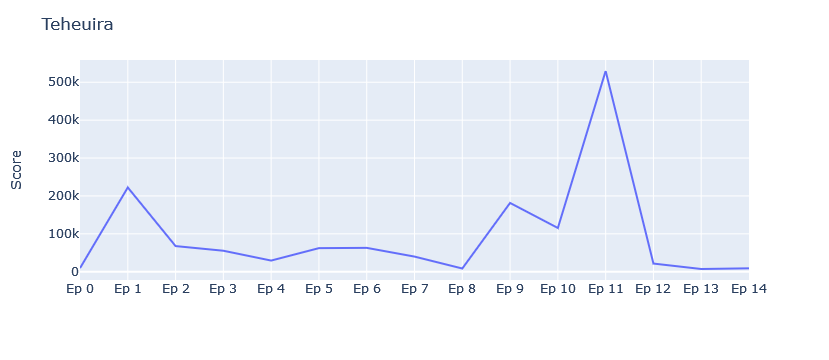

In [116]:
candidat = 'Teheuira'

fig = px.line(x= all_scores.columns, y =all_scores.loc[candidat])
fig.update_yaxes(title='Score')
fig.update_xaxes(title='')
fig.update_layout(title=candidat)

## Normalisation par épisode

In [122]:
# Pour un épisode

# all_scores = gen_all_scores(nom_candidats, 0)
# dfi.export(all_scores.style.highlight_max(color='lightgreen').highlight_min(color='#cd4f39'), 'a.png')

# tmp = round(100*(all_scores - all_scores.min())/(all_scores.max()-all_scores.min()),2)
# dfi.export(tmp.style.highlight_max(color='lightgreen').highlight_min(color='#cd4f39'), 'b.png')

In [158]:
all_scores = gen_all_scores(nom_candidats, 14)
norm_all_scores =100*(all_scores - all_scores.min())/(all_scores.max()-all_scores.min())

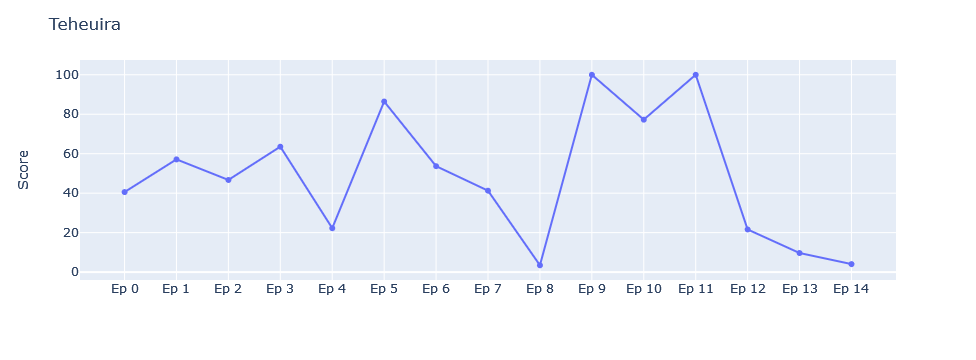

In [210]:
candidat = 'Teheuira'

fig = px.line(x= norm_all_scores.columns, y =norm_all_scores.loc[candidat], markers=True)
fig.update_yaxes(title='Score')
fig.update_xaxes(title='')
fig.update_layout(title=candidat)

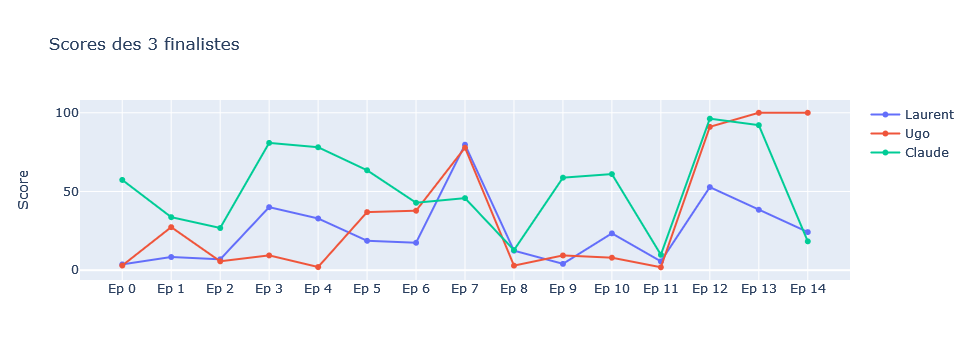

In [209]:
candidats = ['Laurent', 'Ugo', 'Claude']
x_val = norm_all_scores.columns

fig = go.Figure()
for nom in candidats:
    fig.add_trace(go.Scatter(x=x_val, y=norm_all_scores.loc[nom],
                             mode='lines+markers', name=nom))
fig.update_yaxes(title='Score')
fig.update_xaxes(title='')
fig.update_layout(title='Scores des 3 finalistes')


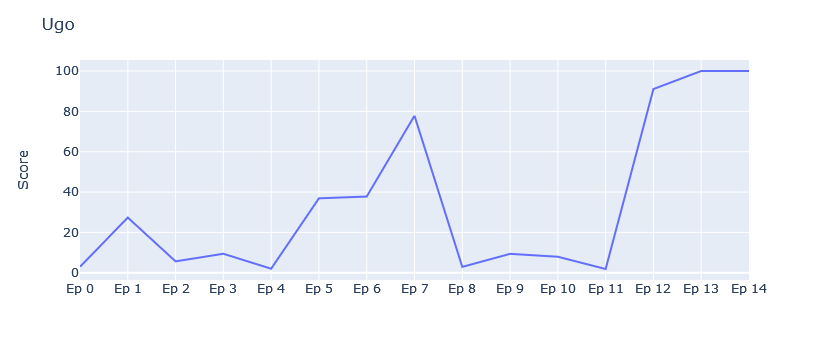

In [160]:
candidat = 'Ugo'

fig = px.line(x= norm_all_scores.columns, y =norm_all_scores.loc[candidat])
fig.update_yaxes(title='Score')
fig.update_xaxes(title='')
fig.update_layout(title=candidat)

---

# Analyse exploratoire

## Wordcloud

[Lemmatization Lefff](https://github.com/sammous/spacy-lefff])

In [13]:
@Language.factory('french_lemmatizer')
def create_french_lemmatizer(nlp, name):
    return LefffLemmatizer(after_melt=True, default=True)

@Language.factory('melt_tagger')  
def create_melt_tagger(nlp, name):
    return POSTagger()

nlp = spacy.load('fr_core_news_sm')
nlp.add_pipe('melt_tagger', after='parser')
nlp.add_pipe('french_lemmatizer', after='melt_tagger')

In [23]:
def plot_wordcloud_cv(nom_candidat, until_em, stop_words_fr, im_size=(2000,2000), random_state=0, colors_palette= None):
    w = all_infos(nom_candidat, until_em).reset_index() # Récupère tous les tweets sur un candidat
    
    all_results, _ = surnoms_trouves(nom_candidat)
    stop_words_fr.update(all_results)

    w.content = w.content.apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words_fr]))

    def multiply_content(row):
        multiply = (min(round(row.retweetCount/100), 20)) # On multiplie le tweet max par 20 fois
        return (row.content+' ')*(multiply+1)

    # w.content = w.apply(multiply_content, axis=1)    
    all_text = ' '.join(w.content)

    vectorizer = CountVectorizer(min_df=50, stop_words=stop_words_fr, ngram_range=(1,3))
    X = vectorizer.fit_transform(w.content)
    
    count = pd.DataFrame(data=X.toarray(), columns = vectorizer.get_feature_names_out()).sum().sort_values(ascending=False)
    frequency = (count/count.max()).to_dict()
    
    # WordCloud !
    img = cv2.imread('./wordcloud/Totem2.png')
    res = cv2.resize(img, dsize=im_size, interpolation=cv2.INTER_CUBIC)

    wc = WordCloud(stopwords=stop_words_fr, font_path='./wordcloud/Staatliches-Regular.ttf',
                   background_color=None, mask=res, contour_width=0, mode='RGBA',
                   max_font_size=256, min_word_length=3, max_words=2000, 
                   width=res.shape[1], height=res.shape[0],
                   random_state=random_state)
    
    wc.generate_from_frequencies(frequency)
    
    if colors_palette == None:
        plt.imshow(wc, interpolation="bilinear")
    else:
        def get_color_func(word, font_size, position, orientation, random_state=None,
            **kwargs):
            return get_single_color_func(random.choice(colors_palette))()
        
        plt.imshow(wc.recolor(color_func=get_color_func, random_state=3),
           interpolation="bilinear")
        
    plt.axis('off')
    plt.show()
    
    return wc, count

# Suppression des stop words
stop_words_fr = set(stopwords.words('french'))
stop_words_fr.update(['koh', 'lanta', 'va', 'c\'est', 'trop', 'fait', 'comme',  'plus', 'vraiment', 'tellement', 'meme', 'qu\'il', 'faire', 'quand', 'etre', 'ça', 'là', 'si'])
stop_words_fr.update(['visage_qui_pleure_à_chaudes_larmes', 'visage_riant_aux_larmes', 'se_rouler_par_terre_de_rire'])   

stop_words_no_name = set(stopwords.words('french'))
stop_words_no_name.update(['koh', 'lanta', 'apres', 'avoir', 'va', 'alors', 'quoi', 'non', 'bien','c\'est', 'trop', 'fait', 'comme',  'plus', 'vraiment', 'tellement', 'meme', 'qu\'il', 'faire', 'quand', 'etre', 'tout','etait', 'cette', 'ça', 'là', 'si'])
stop_words_no_name.update(['visage_qui_pleure_à_chaudes_larmes', 'visage_riant_aux_larmes', 'se_rouler_par_terre_de_rire'])   

for nom in nom_candidats:
    surnoms, _ = surnoms_trouves(nom)
    stop_words_no_name.update(surnoms)    

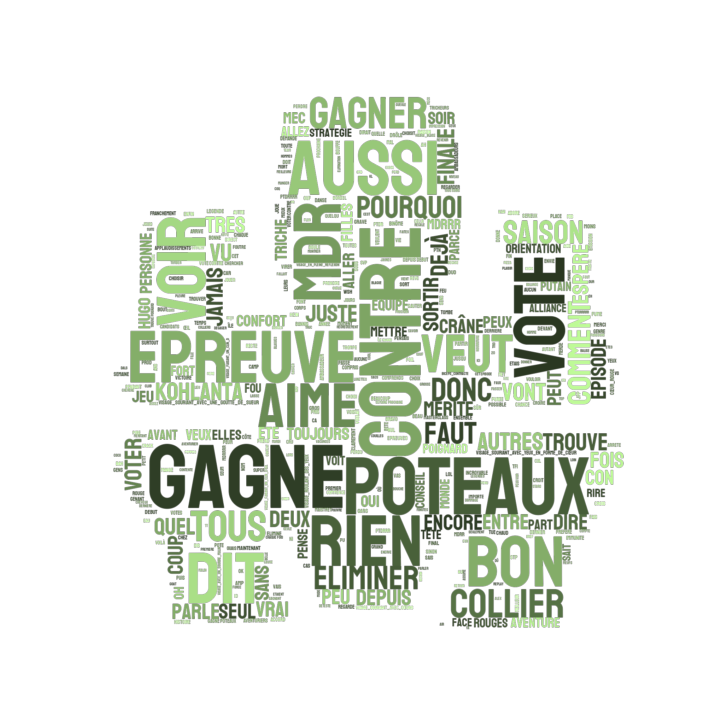

In [213]:
_, _ = plot_wordcloud_cv('Laurent', 14, stop_words_no_name, colors_palette = ['#ABE188'])

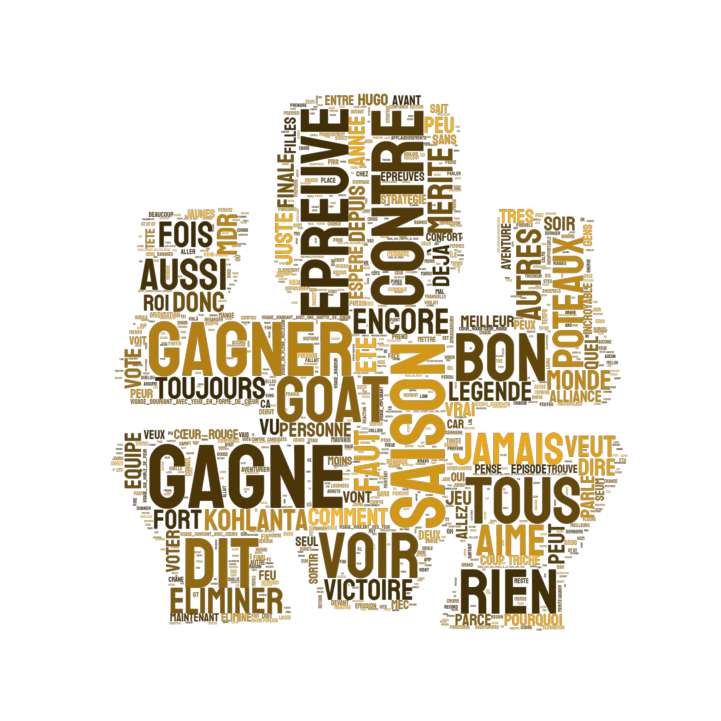

In [211]:
_, _ = plot_wordcloud_cv('Claude', 14, stop_words_no_name, colors_palette = ['#FFB71B'])

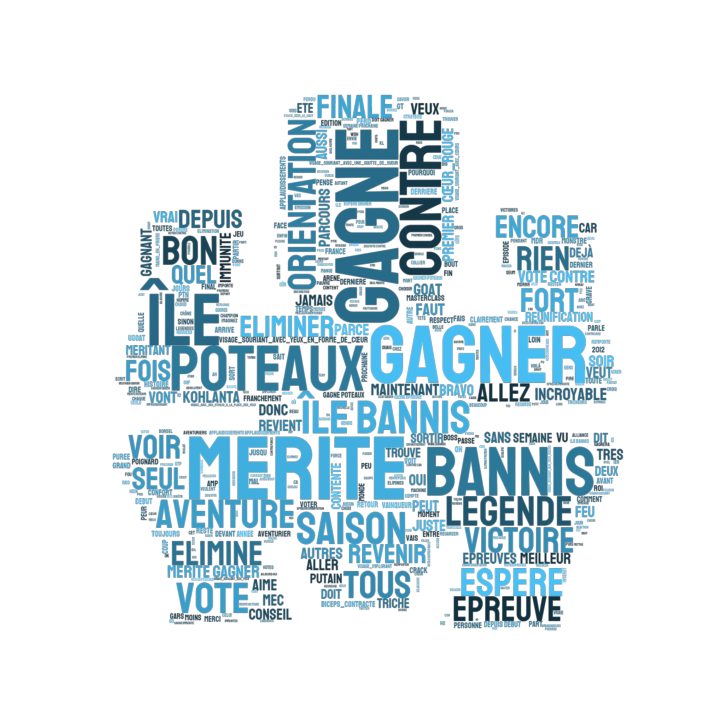

In [214]:
_, _ = plot_wordcloud_cv('Ugo', 14, stop_words_no_name, random_state=2, colors_palette = ['#42B4E6'])

## Quel candidat a le plus souvent fait le + parler de lui ?

In [207]:
(norm_all_scores == 100).sum(axis=1).sort_values(ascending=False)

Coumba        5
Sam           2
Teheuira      2
Ugo           2
Loic          1
Clementine    1
Denis         1
Alexandra     1
Jade          0
Maxime        0
Laurent       0
Candice       0
Karima        0
Claude        0
Cindy         0
Namadia       0
Christelle    0
Patrick       0
Clemence      0
Phil          0
Alix          0
Freddy        0
dtype: int64

## Quel candidat a provoqué globalement le plus de réactions ?

In [208]:
all_scores.sum(axis=1).sort_values(ascending=False)

Teheuira      1422567
Sam           1151212
Coumba        1079872
Claude         984867
Ugo            707817
Alexandra      543836
Loic           526773
Phil           508268
Laurent        473021
Denis          403685
Clementine     364735
Clemence       328281
Alix           315848
Namadia        312498
Karima         265814
Jade           246508
Freddy         212311
Cindy          131002
Christelle      99497
Patrick         87208
Candice         74998
Maxime          52151
dtype: int64

## Nombre de likes, tweets, retweets provoqués par émission par candidat

In [193]:
def get_all_reactions(nom, until_em, dfs, display=True):
    results= pd.DataFrame()
    for num in range(0,until_em+1):
        path = f'./data_jugement/em{num}/'
        df_all = dfs[num]
        df = pd.read_csv(path + nom.lower() + '.csv')
        tmp = pd.DataFrame([df.shape[0]/df_all.shape[0],
                            df.likeCount.sum()/df_all.likeCount.sum(),
                            df.retweetCount.sum()/df_all.retweetCount.sum()],
                           columns=[f'Episode {num}'], index=['nb_tweets', 'nb_retweets', 'nb_likes'])
        results = pd.concat([results, tmp], axis=1)
    fig = go.Figure(data=[
        go.Bar(name='nb_tweets', x=results.columns, y=results.loc['nb_tweets']*100),
        go.Bar(name='nb_retweets', x=results.columns, y=results.loc['nb_retweets']*100),
        go.Bar(name='nb_likes', x=results.columns, y=results.loc['nb_likes']*100)
    ])
    # Change the bar mode
    fig.update_layout(barmode='group')
    fig.update_xaxes(tickangle=90)
    fig.update_layout(title=nom)
    # fig.update_yaxes(type="log")
    if display:
        fig.show()
        
    return results, fig

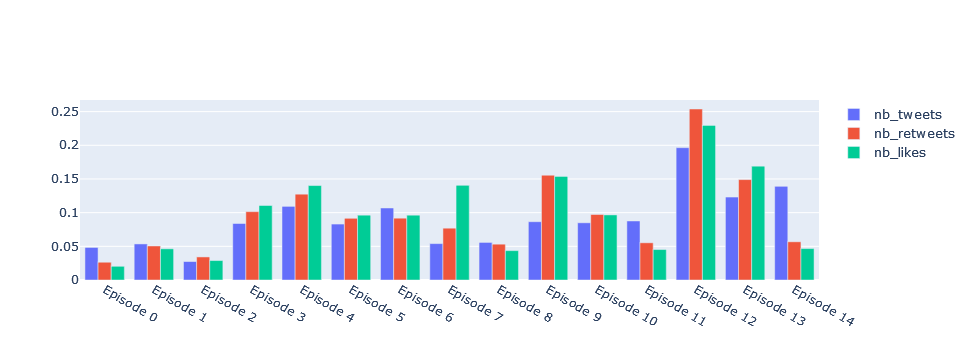

,Episode 0,Episode 1,Episode 2,Episode 3,Episode 4,Episode 5,Episode 6,Episode 7,Episode 8,Episode 9,Episode 10,Episode 11,Episode 12,Episode 13,Episode 14
nb_tweets,0.048345,0.053564,0.027447,0.083876,0.109346,0.083088,0.106897,0.054052,0.055804,0.086556,0.084958,0.087660,0.196471,0.123198,0.139114
nb_retweets,0.026418,0.050538,0.034236,0.101449,0.127411,0.091643,0.091800,0.076949,0.053210,0.155600,0.097261,0.055264,0.253878,0.149082,0.056759
nb_likes,0.020383,0.046301,0.028906,0.110655,0.140260,0.096277,0.096241,0.140621,0.043599,0.153769,0.096669,0.045217,0.229481,0.168984,0.046669


In [138]:
get_all_reactions('Claude', 14, dfs)

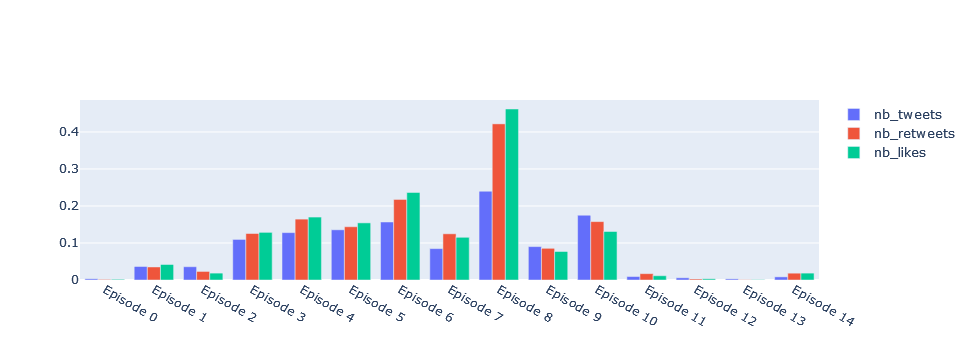

,Episode 0,Episode 1,Episode 2,Episode 3,Episode 4,Episode 5,Episode 6,Episode 7,Episode 8,Episode 9,Episode 10,Episode 11,Episode 12,Episode 13,Episode 14
nb_tweets,0.003264,0.036524,0.035887,0.109663,0.128032,0.135661,0.156733,0.084826,0.239813,0.090239,0.175083,0.009334,0.005974,0.003017,0.008471
nb_retweets,0.001623,0.035236,0.023115,0.125667,0.164602,0.143879,0.217648,0.124825,0.421907,0.085589,0.157840,0.017171,0.002768,0.000679,0.018522
nb_likes,0.001876,0.041948,0.018665,0.128728,0.170031,0.154333,0.236552,0.115450,0.462014,0.077012,0.131051,0.011473,0.003198,0.000853,0.018682


In [139]:
get_all_reactions('Coumba', 14, dfs)

## Info complète sur candidat

In [198]:
def info_candidat(nom_candidat, until_em, stopwords):
    '''
    Retourne différentes infos sur un candidat:
    - Son wordcloud associé
    - Les 3 tweets le concernant les plus populaires
    - Les 5 mots les plus utilisés quand on parle de lui
    - Répartition des tweets dans le temps
    - Nombre de tweets / Nombre de likes / Nombre de retweets
    '''
    
    df = all_infos(nom_candidat, until_em)
    print(f'Total tweets: {df.shape[0]},\nTotal likes: {df.likeCount.sum()},\nTotal retweets: {df.retweetCount.sum()}')
    

    
    print('Top 3 des tweets les plus retweetés')
    display(df.sort_values(by='retweetCount', ascending=False).head(3))
    
    wc, words_count = plot_wordcloud_cv(nom_candidat, 14, stopwords)
    print('Mots les plus utilisés:')
    display(words_count.head(10))


---

# Pour mieux comprendre

## NER

---

In [90]:
%%time
tweet_sample = df_em2
tweet_sample.content = tweet_sample.content.apply(nlp_pipeline)

# Par batch de 512, récupère l'ensemble des entités "Personnes" trouvées dans le contenu des tweets
persons = []
start = 0
for stop in range(0, tweet_sample.shape[0], 512):
    output = nlp(' '.join(tweet_sample.iloc[start:stop].content.values)) # Concatène 512 tweets en un seul string
    start = stop
    for entity in output:
        if entity['entity_group'] == 'PER':
            persons.append(entity['word']) # Ajoute l'entité reconnue à notre liste

Wall time: 2min 30s


In [162]:
tmp = persons

tmp = list(map(lambda x: x.split(), tmp)) # On éclate en un unique mots les entités contenant plusieurs mots (Ex: 'Claude le meilleur')
clean = []
for nom in tmp:
    if type(nom)==list:
        clean += nom
    else:
        clean.append(nom)
clean = [nom for nom in clean if (len(nom) > 2 and len(nom) < 13)]
clean = np.unique(clean)
clean

array(['ade', 'ahmad', 'alex', 'alexandra', 'alexia', 'alix', 'amed',
       'ana', 'arnaud', 'aubrey', 'aure', 'auville', 'ayunemin',
       'azyllor', 'baquet', 'beka', 'benjamin', 'benzema', 'bertrand',
       'biceps', 'blaze', 'bou', 'brad', 'brognard', 'brogniart',
       'candice', 'canner', 'canteloup', 'cauet', 'ceo', 'chtijug',
       'cindy', 'cla', 'claud', 'claude', 'clem', 'clemence',
       'clementine', 'couba', 'coumba', 'covid', 'cumba', 'curry',
       'davibasteni', 'declo', 'denis', 'deschamps', 'deujna', 'dheliat',
       'digne', 'dimabah', 'domingo', 'drizzle152', 'dubois',
       'dupontaignan', 'duriani', 'ele', 'els', 'eric', 'etchebest',
       'evelyne', 'feu', 'fpoisson78', 'freddy', 'fredzoul', 'girardot',
       'grandlarge', 'griezmann', 'gwen', 'hadja', 'hurler', 'hutao',
       'imbecile', 'ine', 'inefabienco', 'jade', 'javier', 'jong',
       'josepaumard', 'jules', 'julienngh', 'kamal', 'kante', 'kar',
       'karim', 'karima', 'khey', 'kimpembe', '

In [225]:
surnoms_trouvés['Freddy'] = np.append(np.array('1 2'),'oik')
surnoms_trouvés

{'Freddy': array(['1 2', 'oik'], dtype='<U3'),
 'Teheuira': array(['teheiura', 'teheuira', 'tehura', 'theuira'], dtype='<U12'),
 'Patrick': array(['patrick', 'patrik'], dtype='<U12'),
 'Alexandra': array(['alexandra'], dtype='<U12'),
 'Cindy': array(['cindy'], dtype='<U12'),
 'Claude': array(['claud', 'claude'], dtype='<U12'),
 'Karima': array(['karim', 'karima'], dtype='<U12'),
 'Jade': array(['ade', 'jade'], dtype='<U12'),
 'Maxime': array(['maxime'], dtype='<U12'),
 'Laurent': array(['laurent'], dtype='<U12'),
 'Candice': array(['candice'], dtype='<U12'),
 'Sam': array(['sam'], dtype='<U12'),
 'Clementine': array(['clementine'], dtype='<U12'),
 'Ugo': array(['ugo'], dtype='<U12'),
 'Namadia': array(['namadia'], dtype='<U12'),
 'Christelle': array([], dtype='<U12'),
 'Coumba': array(['couba', 'coumba', 'cumba', 'umba'], dtype='<U12'),
 'Loic': array(['loic', 'loïc'], dtype='<U12'),
 'Clemence': array(['clemence'], dtype='<U12'),
 'Phil': array(['phil'], dtype='<U12'),
 'Alix': array(

In [228]:
surnoms_trouvés = {}

for nom in nom_candidats:
    res = []
    distance_max = round(len(nom)*0.25) # La distance de levenshtein maximum acceptée pour considérer cela comme une faute de frappe/Une autre appellation du candidat
    for entity in clean: # Calcul de la distance pour chaque entité trouvée
        res.append(distance(entity, nom.lower()))
    res = pd.Series(res)
    surnoms_trouvés[nom] = np.unique(np.append(clean[res[res <= distance_max].index], nom.lower()))
    
surnoms_trouvés

{'Freddy': array(['freddy'], dtype='<U12'),
 'Teheuira': array(['teheiura', 'teheuira', 'tehura', 'theuira'], dtype='<U12'),
 'Patrick': array(['patrick', 'patrik'], dtype='<U12'),
 'Alexandra': array(['alexandra'], dtype='<U12'),
 'Cindy': array(['cindy'], dtype='<U12'),
 'Claude': array(['claud', 'claude'], dtype='<U12'),
 'Karima': array(['karim', 'karima'], dtype='<U12'),
 'Jade': array(['ade', 'jade'], dtype='<U12'),
 'Maxime': array(['maxime'], dtype='<U12'),
 'Laurent': array(['laurent'], dtype='<U12'),
 'Candice': array(['candice'], dtype='<U12'),
 'Sam': array(['sam'], dtype='<U12'),
 'Clementine': array(['clementine'], dtype='<U12'),
 'Ugo': array(['ugo'], dtype='<U12'),
 'Namadia': array(['namadia'], dtype='<U12'),
 'Christelle': array(['christelle'], dtype='<U12'),
 'Coumba': array(['couba', 'coumba', 'cumba', 'umba'], dtype='<U12'),
 'Loic': array(['loic', 'loïc'], dtype='<U12'),
 'Clemence': array(['clemence'], dtype='<U12'),
 'Phil': array(['phil'], dtype='<U12'),
 'Alix